In [5]:
import os.path

import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
import gc

from lightgbm.sklearn import LGBMClassifier
from sklearn.model_selection import KFold,train_test_split
import matplotlib.pyplot as plt
import joblib
from sklearn.metrics import f1_score, recall_score, precision_score
from tqdm import tqdm
from sklearn.model_selection import GridSearchCV

In [6]:
# 超参数设置
K_FOLD = 5
Random_seed = 2023
if_duikang = False
save_model_dir_name = '0701_2003'
save_model_dir_path = os.path.join('./save_models', save_model_dir_name)
# sava_model_dir_name = '1'

if not os.path.exists(save_model_dir_path):
    os.makedirs(save_model_dir_path)

In [7]:
# input_datapath_list = ["processed_data/71_021.csv", "processed_data/gov1.csv", 'processed_data/other.csv']
# all_data = pd.read_csv(input_datapath_list[2], encoding='latin-1')
# all_data

In [8]:
%time
input_datapath_list = ["processed_data/701_1434.csv", "processed_data/gov2.csv", 'processed_data/other_new.csv', 'processed_data/honor.csv', 'processed_data/政府供应特征.csv', 'processed_data/gov_cat.csv']
for i, datapath in enumerate(input_datapath_list):
    if i == 0:
        all_data = pd.read_csv(input_datapath_list[i])
        all_data['Y'] = all_data['Y'].fillna(-1)
        all_data = all_data.sort_values('ID')
    else:
        temp_data = pd.read_csv(input_datapath_list[i])
        temp_data['Y'] = temp_data['Y'].fillna(-1)
        temp_data = temp_data.sort_values('ID')
        all_features_temp = [x for x in temp_data.columns if x not in ['Unnamed: 0', 'ID', 'score','Y',]]

        all_data[all_features_temp] = temp_data[all_features_temp]


# all_data1 = pd.read_csv("processed_data/71_021.csv")
# all_data2 =  pd.read_csv("processed_data/gov1.csv")

CPU times: total: 0 ns
Wall time: 0 ns


In [9]:
all_data.to_csv('./processed_data/all_data.csv', index = False)

In [10]:
# all_data = all_data1.merge(all_data2, on=['ID','Y'], how='left')

In [11]:
list(all_data.columns)

['ID',
 'score',
 'Y',
 '著作保护作品数',
 '著作保护作品类别数',
 '专利数',
 '专利类别数',
 '专利_发明_数量',
 '专利_实用新型_数量',
 '专利_外观设计_数量',
 '无效_专利_数量',
 '有效_专利_数量',
 '失效_专利_数量',
 '审中_专利_数量',
 '2010年_专利数量',
 '2010年_专利类别数',
 '2010年_专利_发明_数量',
 '2010年_专利_实用新型_数量',
 '2010年_专利_外观设计_数量',
 '2010年_无效_专利_数量',
 '2010年_有效_专利_数量',
 '2010年_失效_专利_数量',
 '2010年_审中_专利_数量',
 '2011年_专利数量',
 '2011年_专利类别数',
 '2011年_专利_发明_数量',
 '2011年_专利_实用新型_数量',
 '2011年_专利_外观设计_数量',
 '2011年_无效_专利_数量',
 '2011年_有效_专利_数量',
 '2011年_失效_专利_数量',
 '2011年_审中_专利_数量',
 '2012年_专利数量',
 '2012年_专利类别数',
 '2012年_专利_发明_数量',
 '2012年_专利_实用新型_数量',
 '2012年_专利_外观设计_数量',
 '2012年_无效_专利_数量',
 '2012年_有效_专利_数量',
 '2012年_失效_专利_数量',
 '2012年_审中_专利_数量',
 '2013年_专利数量',
 '2013年_专利类别数',
 '2013年_专利_发明_数量',
 '2013年_专利_实用新型_数量',
 '2013年_专利_外观设计_数量',
 '2013年_无效_专利_数量',
 '2013年_有效_专利_数量',
 '2013年_失效_专利_数量',
 '2013年_审中_专利_数量',
 '2014年_专利数量',
 '2014年_专利类别数',
 '2014年_专利_发明_数量',
 '2014年_专利_实用新型_数量',
 '2014年_专利_外观设计_数量',
 '2014年_无效_专利_数量',
 '2014年_有效_专利_数量',
 '2014年_失效_专利_数量',
 '2014年_审中_专利_数量'

In [12]:
label = 'Y' # 标签所在列名
if if_duikang:
    all_train_data =  all_data #[all_data['Y']!=-1]
    all_train_data.loc[all_train_data['Y']!=-1, 'Y'] = 1
    all_train_data.loc[all_train_data['Y']==-1, 'Y'] = 0
else:
    all_train_data =  all_data[all_data['Y']!=-1]
# from sklearn.datasets import load_iris
# # 加载Iris数据集
# iris = load_iris()
#
# # 获取特征和标签
# dftrain_X = iris.data  # 特征数据
# dftrain_Y = iris.target  # 标签数据


In [13]:
all_train_data

,ID,score,Y,著作保护作品数,著作保护作品类别数,专利数,专利类别数,专利_发明_数量,专利_实用新型_数量,专利_外观设计_数量,...,2023年_政府支持拼接_拟补助_数量,2023年_政府支持拼接_通过审核_数量,2023年_政府支持拼接_拟支_数量,2023年_政府支持拼接_奖励_数量,2023年_政府支持拼接_培育_数量,2023年_政府支持拼接_推荐_数量,2023年_政府支持拼接_拟奖励_数量,2023年_政府支持拼接_国家级_数量,2023年_政府支持拼接_省级_数量,2023年_政府支持拼接_市级_数量
3924,corp_1000001,NaN,1.0,NaN,NaN,562.0,3.0,331.0,214.0,17.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
654,corp_1000002,NaN,0.0,NaN,NaN,71.0,2.0,11.0,60.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
767,corp_1000003,NaN,1.0,2.0,1.0,72.0,3.0,30.0,20.0,22.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4783,corp_1000004,NaN,1.0,NaN,NaN,438.0,2.0,277.0,161.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
686,corp_1000005,NaN,0.0,NaN,NaN,76.0,2.0,72.0,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2589,corp_1005017,NaN,0.0,NaN,NaN,106.0,2.0,21.0,85.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2398,corp_1005018,NaN,0.0,1.0,1.0,119.0,3.0,25.0,86.0,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1276,corp_1005019,NaN,0.0,NaN,NaN,933.0,2.0,136.0,797.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4521,corp_1005020,NaN,0.0,NaN,NaN,26.0,2.0,10.0,16.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
all_features = list(all_train_data.columns)
all_features = [x for x in all_features if x not in ['Unnamed: 0', 'ID', 'score','Y',]]

In [15]:
dftrain_X = all_train_data[all_features]
dftrain_Y = all_train_data[label]


In [16]:
# 空数据全填0
dftrain_X = dftrain_X.fillna(0)

In [17]:
dftrain_X

,著作保护作品数,著作保护作品类别数,专利数,专利类别数,专利_发明_数量,专利_实用新型_数量,专利_外观设计_数量,无效_专利_数量,有效_专利_数量,失效_专利_数量,...,2023年_政府支持拼接_拟补助_数量,2023年_政府支持拼接_通过审核_数量,2023年_政府支持拼接_拟支_数量,2023年_政府支持拼接_奖励_数量,2023年_政府支持拼接_培育_数量,2023年_政府支持拼接_推荐_数量,2023年_政府支持拼接_拟奖励_数量,2023年_政府支持拼接_国家级_数量,2023年_政府支持拼接_省级_数量,2023年_政府支持拼接_市级_数量
3924,0.0,0.0,562.0,3.0,331.0,214.0,17.0,40.0,407.0,29.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
654,0.0,0.0,71.0,2.0,11.0,60.0,0.0,2.0,42.0,25.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
767,2.0,1.0,72.0,3.0,30.0,20.0,22.0,6.0,50.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4783,0.0,0.0,438.0,2.0,277.0,161.0,0.0,57.0,273.0,24.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
686,0.0,0.0,76.0,2.0,72.0,4.0,0.0,8.0,54.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2589,0.0,0.0,106.0,2.0,21.0,85.0,0.0,7.0,81.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2398,1.0,1.0,119.0,3.0,25.0,86.0,8.0,1.0,110.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1276,0.0,0.0,933.0,2.0,136.0,797.0,0.0,7.0,761.0,57.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4521,0.0,0.0,26.0,2.0,10.0,16.0,0.0,0.0,23.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
# param_grid = {
#     'n_estimators': [100, 200, 300],  # 决策树的数量
#     'learning_rate': [0.1, 0.05, 0.01],  # 学习率
#     'max_depth': [3, 5, 7],  # 决策树的最大深度
#     'num_leaves': [31, 63, 127],  # 叶子节点数目
#     'min_child_samples': [20, 50, 100],  # 每个叶子节点的最小样本数
#     'subsample': [0.8, 0.9, 1.0],  # 每次迭代使用的子样本比例
#     'colsample_bytree': [0.8, 0.9, 1.0],  # 每棵树使用的特征比例
#     'reg_alpha': [0, 0.1, 0.5],  # L1 正则化项的权重
#     'reg_lambda': [0, 0.1, 0.5],  # L2 正则化项的权重
#     # 其他需要调节的超参数...
# }

In [19]:
def find_best_threshold_reg(y_valid, oof_prob):
    best_f1 = 0
    best_th = 0
    ths=[]
    f1s=[]
    for th in tqdm([i/100 for i in range(0, 70)]):
        # print('th:', th)
        oof_prob_copy = oof_prob.copy()
        oof_prob_copy[oof_prob_copy >= th] = 1
        oof_prob_copy[oof_prob_copy < th] = 0
        recall = recall_score(y_valid, oof_prob_copy)
        precision = precision_score(y_valid, oof_prob_copy)
        f1 = 2*recall*precision / (precision+recall)
        # mape = np.mean(np.abs(oof_prob_copy-y_valid)/y_valid)
        ths.append(th)
        f1s.append(f1)
        if f1 > best_f1:
            best_th = th
            best_f1 = f1
        gc.collect()

    return best_th, best_f1, ths, f1s  # best_mape, ths,mapes

Fold: 1
[1]	valid_0's binary_logloss: 0.677322	valid_0's auc: 0.738924
[2]	valid_0's binary_logloss: 0.675006	valid_0's auc: 0.741821
[3]	valid_0's binary_logloss: 0.672759	valid_0's auc: 0.742353
[4]	valid_0's binary_logloss: 0.670364	valid_0's auc: 0.749583
[5]	valid_0's binary_logloss: 0.66805	valid_0's auc: 0.751678
[6]	valid_0's binary_logloss: 0.665612	valid_0's auc: 0.757672
[7]	valid_0's binary_logloss: 0.663216	valid_0's auc: 0.763456
[8]	valid_0's binary_logloss: 0.663978	valid_0's auc: 0.763347
[9]	valid_0's binary_logloss: 0.661747	valid_0's auc: 0.765768
[10]	valid_0's binary_logloss: 0.65947	valid_0's auc: 0.76688


C:\Users\HP\Anaconda3\envs\new_pytorch\lib\site-packages\lightgbm\callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[11]	valid_0's binary_logloss: 0.657425	valid_0's auc: 0.766613
[12]	valid_0's binary_logloss: 0.658127	valid_0's auc: 0.767056
[13]	valid_0's binary_logloss: 0.655922	valid_0's auc: 0.769112
[14]	valid_0's binary_logloss: 0.653605	valid_0's auc: 0.771816
[15]	valid_0's binary_logloss: 0.651505	valid_0's auc: 0.773129
[16]	valid_0's binary_logloss: 0.649317	valid_0's auc: 0.77485
[17]	valid_0's binary_logloss: 0.64748	valid_0's auc: 0.773702
[18]	valid_0's binary_logloss: 0.645446	valid_0's auc: 0.775082
[19]	valid_0's binary_logloss: 0.643396	valid_0's auc: 0.776752
[20]	valid_0's binary_logloss: 0.641491	valid_0's auc: 0.777768
[21]	valid_0's binary_logloss: 0.641941	valid_0's auc: 0.777765
[22]	valid_0's binary_logloss: 0.640063	valid_0's auc: 0.778035
[23]	valid_0's binary_logloss: 0.638154	valid_0's auc: 0.778819
[24]	valid_0's binary_logloss: 0.636305	valid_0's auc: 0.78013
[25]	valid_0's binary_logloss: 0.634379	valid_0's auc: 0.78096
[26]	valid_0's binary_logloss: 0.632587	vali

100%|██████████| 70/70 [00:04<00:00, 15.23it/s]


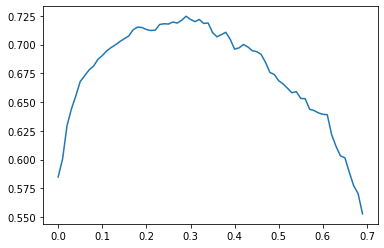

Fold: 2
[1]	valid_0's binary_logloss: 0.660431	valid_0's auc: 0.770472
[2]	valid_0's binary_logloss: 0.657793	valid_0's auc: 0.774484
[3]	valid_0's binary_logloss: 0.655253	valid_0's auc: 0.775044
[4]	valid_0's binary_logloss: 0.65276	valid_0's auc: 0.779287
[5]	valid_0's binary_logloss: 0.650414	valid_0's auc: 0.779008
[6]	valid_0's binary_logloss: 0.648096	valid_0's auc: 0.785118
[7]	valid_0's binary_logloss: 0.645855	valid_0's auc: 0.785528
[8]	valid_0's binary_logloss: 0.64666	valid_0's auc: 0.784445
[9]	valid_0's binary_logloss: 0.644422	valid_0's auc: 0.784237
[10]	valid_0's binary_logloss: 0.642138	valid_0's auc: 0.78577
[11]	valid_0's binary_logloss: 0.639925	valid_0's auc: 0.787245
[12]	valid_0's binary_logloss: 0.64071	valid_0's auc: 0.786577
[13]	valid_0's binary_logloss: 0.638486	valid_0's auc: 0.787151
[14]	valid_0's binary_logloss: 0.636358	valid_0's auc: 0.7881


C:\Users\HP\Anaconda3\envs\new_pytorch\lib\site-packages\lightgbm\callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[15]	valid_0's binary_logloss: 0.634367	valid_0's auc: 0.787413
[16]	valid_0's binary_logloss: 0.632215	valid_0's auc: 0.788473
[17]	valid_0's binary_logloss: 0.63048	valid_0's auc: 0.787942
[18]	valid_0's binary_logloss: 0.628456	valid_0's auc: 0.789877
[19]	valid_0's binary_logloss: 0.62689	valid_0's auc: 0.788746
[20]	valid_0's binary_logloss: 0.625085	valid_0's auc: 0.788631
[21]	valid_0's binary_logloss: 0.625541	valid_0's auc: 0.788394
[22]	valid_0's binary_logloss: 0.623893	valid_0's auc: 0.788289
[23]	valid_0's binary_logloss: 0.622204	valid_0's auc: 0.788862
[24]	valid_0's binary_logloss: 0.620708	valid_0's auc: 0.787847
[25]	valid_0's binary_logloss: 0.619052	valid_0's auc: 0.787708
[26]	valid_0's binary_logloss: 0.617332	valid_0's auc: 0.788833
[27]	valid_0's binary_logloss: 0.615693	valid_0's auc: 0.788965
[28]	valid_0's binary_logloss: 0.616266	valid_0's auc: 0.789072
[29]	valid_0's binary_logloss: 0.614818	valid_0's auc: 0.789004
[30]	valid_0's binary_logloss: 0.613301	va

100%|██████████| 70/70 [00:04<00:00, 17.12it/s]


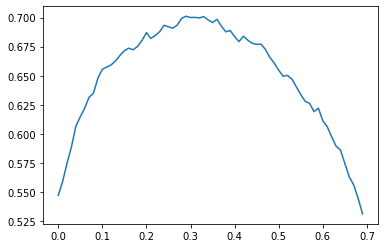

Fold: 3
[1]	valid_0's binary_logloss: 0.656285	valid_0's auc: 0.741378
[2]	valid_0's binary_logloss: 0.653988	valid_0's auc: 0.739773
[3]	valid_0's binary_logloss: 0.651725	valid_0's auc: 0.744063
[4]	valid_0's binary_logloss: 0.64952	valid_0's auc: 0.743499
[5]	valid_0's binary_logloss: 0.647399	valid_0's auc: 0.745682
[6]	valid_0's binary_logloss: 0.645322	valid_0's auc: 0.744907
[7]	valid_0's binary_logloss: 0.643224	valid_0's auc: 0.747896
[8]	valid_0's binary_logloss: 0.643941	valid_0's auc: 0.747992
[9]	valid_0's binary_logloss: 0.641916	valid_0's auc: 0.748125
[10]	valid_0's binary_logloss: 0.639962	valid_0's auc: 0.749187
[11]	valid_0's binary_logloss: 0.637873	valid_0's auc: 0.752365
[12]	valid_0's binary_logloss: 0.638575	valid_0's auc: 0.751891
[13]	valid_0's binary_logloss: 0.636702	valid_0's auc: 0.753235
[14]	valid_0's binary_logloss: 0.634726	valid_0's auc: 0.753861
[15]	valid_0's binary_logloss: 0.632946	valid_0's auc: 0.754465


C:\Users\HP\Anaconda3\envs\new_pytorch\lib\site-packages\lightgbm\callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[16]	valid_0's binary_logloss: 0.631102	valid_0's auc: 0.755585
[17]	valid_0's binary_logloss: 0.629186	valid_0's auc: 0.757331
[18]	valid_0's binary_logloss: 0.627448	valid_0's auc: 0.758055
[19]	valid_0's binary_logloss: 0.625649	valid_0's auc: 0.760022
[20]	valid_0's binary_logloss: 0.624053	valid_0's auc: 0.760717
[21]	valid_0's binary_logloss: 0.62445	valid_0's auc: 0.760504
[22]	valid_0's binary_logloss: 0.622715	valid_0's auc: 0.761829
[23]	valid_0's binary_logloss: 0.621051	valid_0's auc: 0.762673
[24]	valid_0's binary_logloss: 0.619435	valid_0's auc: 0.763722
[25]	valid_0's binary_logloss: 0.617697	valid_0's auc: 0.766202
[26]	valid_0's binary_logloss: 0.616049	valid_0's auc: 0.767847
[27]	valid_0's binary_logloss: 0.614313	valid_0's auc: 0.76983
[28]	valid_0's binary_logloss: 0.614848	valid_0's auc: 0.769614
[29]	valid_0's binary_logloss: 0.61321	valid_0's auc: 0.7709
[30]	valid_0's binary_logloss: 0.611562	valid_0's auc: 0.772577
[31]	valid_0's binary_logloss: 0.611586	valid

100%|██████████| 70/70 [00:03<00:00, 17.70it/s]


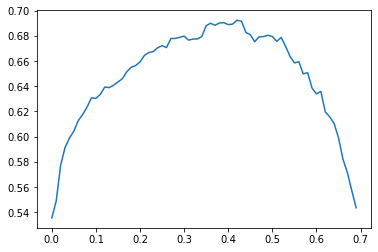

Fold: 4
[1]	valid_0's binary_logloss: 0.672773	valid_0's auc: 0.755361
[2]	valid_0's binary_logloss: 0.670206	valid_0's auc: 0.760828
[3]	valid_0's binary_logloss: 0.667676	valid_0's auc: 0.762317
[4]	valid_0's binary_logloss: 0.665235	valid_0's auc: 0.76124
[5]	valid_0's binary_logloss: 0.66299	valid_0's auc: 0.759964
[6]	valid_0's binary_logloss: 0.660653	valid_0's auc: 0.760735
[7]	valid_0's binary_logloss: 0.658329	valid_0's auc: 0.76246
[8]	valid_0's binary_logloss: 0.65912	valid_0's auc: 0.762199
[9]	valid_0's binary_logloss: 0.656887	valid_0's auc: 0.76265
[10]	valid_0's binary_logloss: 0.654738	valid_0's auc: 0.762447
[11]	valid_0's binary_logloss: 0.652728	valid_0's auc: 0.765369
[12]	valid_0's binary_logloss: 0.653427	valid_0's auc: 0.76461
[13]	valid_0's binary_logloss: 0.651252	valid_0's auc: 0.765481
[14]	valid_0's binary_logloss: 0.649205	valid_0's auc: 0.766299
[15]	valid_0's binary_logloss: 0.64733	valid_0's auc: 0.766063
[16]	valid_0's binary_logloss: 0.645411	valid_0'

C:\Users\HP\Anaconda3\envs\new_pytorch\lib\site-packages\lightgbm\callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[17]	valid_0's binary_logloss: 0.643493	valid_0's auc: 0.767596
[18]	valid_0's binary_logloss: 0.641592	valid_0's auc: 0.768488
[19]	valid_0's binary_logloss: 0.639823	valid_0's auc: 0.767816
[20]	valid_0's binary_logloss: 0.638051	valid_0's auc: 0.768213
[21]	valid_0's binary_logloss: 0.638445	valid_0's auc: 0.768526
[22]	valid_0's binary_logloss: 0.636552	valid_0's auc: 0.770043
[23]	valid_0's binary_logloss: 0.634782	valid_0's auc: 0.771058
[24]	valid_0's binary_logloss: 0.63317	valid_0's auc: 0.77073
[25]	valid_0's binary_logloss: 0.63146	valid_0's auc: 0.771314
[26]	valid_0's binary_logloss: 0.629984	valid_0's auc: 0.770902
[27]	valid_0's binary_logloss: 0.628462	valid_0's auc: 0.771327
[28]	valid_0's binary_logloss: 0.629021	valid_0's auc: 0.771317
[29]	valid_0's binary_logloss: 0.627567	valid_0's auc: 0.771353
[30]	valid_0's binary_logloss: 0.626093	valid_0's auc: 0.771694
[31]	valid_0's binary_logloss: 0.626117	valid_0's auc: 0.772096
[32]	valid_0's binary_logloss: 0.624612	val

100%|██████████| 70/70 [00:04<00:00, 16.66it/s]


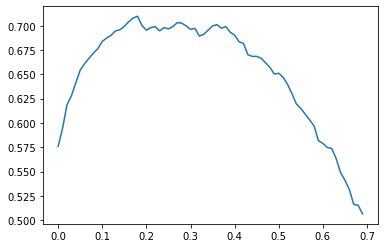

Fold: 5
[1]	valid_0's binary_logloss: 0.668727	valid_0's auc: 0.746912
[2]	valid_0's binary_logloss: 0.666288	valid_0's auc: 0.747798
[3]	valid_0's binary_logloss: 0.663971	valid_0's auc: 0.748923
[4]	valid_0's binary_logloss: 0.661672	valid_0's auc: 0.749873
[5]	valid_0's binary_logloss: 0.659446	valid_0's auc: 0.748268
[6]	valid_0's binary_logloss: 0.657131	valid_0's auc: 0.750679
[7]	valid_0's binary_logloss: 0.654988	valid_0's auc: 0.751707
[8]	valid_0's binary_logloss: 0.655747	valid_0's auc: 0.751846
[9]	valid_0's binary_logloss: 0.653602	valid_0's auc: 0.753545
[10]	valid_0's binary_logloss: 0.651536	valid_0's auc: 0.754536
[11]	valid_0's binary_logloss: 0.649509	valid_0's auc: 0.755522
[12]	valid_0's binary_logloss: 0.650203	valid_0's auc: 0.755399
[13]	valid_0's binary_logloss: 0.648112	valid_0's auc: 0.757242

C:\Users\HP\Anaconda3\envs\new_pytorch\lib\site-packages\lightgbm\callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')



[14]	valid_0's binary_logloss: 0.646252	valid_0's auc: 0.757136
[15]	valid_0's binary_logloss: 0.644281	valid_0's auc: 0.758817
[16]	valid_0's binary_logloss: 0.642354	valid_0's auc: 0.760516
[17]	valid_0's binary_logloss: 0.640535	valid_0's auc: 0.76058
[18]	valid_0's binary_logloss: 0.638816	valid_0's auc: 0.760681
[19]	valid_0's binary_logloss: 0.637008	valid_0's auc: 0.762238
[20]	valid_0's binary_logloss: 0.635235	valid_0's auc: 0.763162
[21]	valid_0's binary_logloss: 0.635681	valid_0's auc: 0.76302
[22]	valid_0's binary_logloss: 0.633865	valid_0's auc: 0.764006
[23]	valid_0's binary_logloss: 0.632214	valid_0's auc: 0.763908
[24]	valid_0's binary_logloss: 0.63054	valid_0's auc: 0.764461
[25]	valid_0's binary_logloss: 0.628874	valid_0's auc: 0.76554
[26]	valid_0's binary_logloss: 0.627331	valid_0's auc: 0.765468
[27]	valid_0's binary_logloss: 0.625612	valid_0's auc: 0.767053
[28]	valid_0's binary_logloss: 0.626205	valid_0's auc: 0.766857
[29]	valid_0's binary_logloss: 0.624664	val

100%|██████████| 70/70 [00:04<00:00, 16.05it/s]


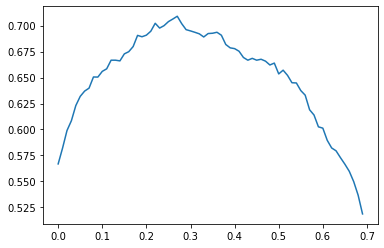

In [20]:
# 数据集划分
best_th_list = []
best_f1_list = []
folds = KFold(n_splits=5, shuffle=True, random_state=Random_seed)
for fold_, (trn_idx, val_idx) in enumerate(folds.split(dftrain_X, dftrain_Y)):
    print('Fold:', fold_+1)
    tr_x, tr_y = dftrain_X.iloc[trn_idx, :], dftrain_Y.iloc[trn_idx]
    vl_x, vl_y = dftrain_X.iloc[val_idx, :], dftrain_Y.iloc[val_idx]

    model = LGBMClassifier(
    num_leaves=128,
        metric='auc',
        boosting_type="dart",
        max_depth=16,
        learning_rate=0.01,
        reg_alpha=0.0,
        reg_lambda=1,
        n_estimators=2000,
)
    model.fit(tr_x, tr_y,
         eval_set=[(vl_x, vl_y)],
         eval_metric='logloss',
        early_stopping_rounds=30,
         verbose=True)
    y_prob = model.predict_proba(vl_x)[:,1]

    # y_prob = np.where(y_prob>0.5, 1, 0)
    # prob_oof[val_idx] = y_prob
    best_th, best_f1, ths, f1s = find_best_threshold_reg(vl_y.values, y_prob)
    best_th_list.append(best_th)
    best_f1_list.append(best_f1)
    plt.plot(ths, f1s)
    plt.show()
    # break


    # 保存模型
    joblib.dump(model, os.path.join(save_model_dir_path, f'./model_{fold_}.pkl'))



with open(os.path.join(save_model_dir_path, 'threshold.txt'), 'w') as f:
    best_th_list = [str(x) for x in best_th_list]
    f.write(' '.join(best_th_list))

In [22]:
print('mean best f1:', np.mean(best_f1_list)) # 0.7081892599317721

mean best f1: 0.7073445876296309


In [23]:
f1s

[0.5668789808917197,
 0.5821749795584628,
 0.5989847715736041,
 0.6084701815038894,
 0.6230088495575221,
 0.6318631863186318,
 0.6369426751592356,
 0.6397800183318058,
 0.6505125815470643,
 0.6504217432052484,
 0.6559241706161137,
 0.6583732057416268,
 0.6666666666666667,
 0.6666666666666666,
 0.666005946481665,
 0.6727456940222898,
 0.6748466257668713,
 0.6797927461139897,
 0.6905263157894737,
 0.6892177589852009,
 0.6907545164718385,
 0.6945337620578779,
 0.7021739130434782,
 0.6975717439293599,
 0.699889258028793,
 0.7037861915367484,
 0.7062780269058295,
 0.7089467723669308,
 0.7018348623853211,
 0.6960556844547564,
 0.6948356807511736,
 0.693491124260355,
 0.6920332936979786,
 0.6889952153110048,
 0.6923076923076923,
 0.6925880923450791,
 0.6935286935286934,
 0.6906832298136646,
 0.6817610062893081,
 0.6785260482846251,
 0.6777920410783056,
 0.6752910737386805,
 0.6692708333333334,
 0.6666666666666667,
 0.6684420772303595,
 0.6666666666666667,
 0.6675712347354138,
 0.6657534246575

In [24]:
# 打印特征重要性
importance = model.feature_importances_
for feature, importance_value in zip(dftrain_X.columns, importance):
    print(f"{feature}: {importance_value}")

著作保护作品数: 501
著作保护作品类别数: 18
专利数: 3854
专利类别数: 322
专利_发明_数量: 5786
专利_实用新型_数量: 3527
专利_外观设计_数量: 1316
无效_专利_数量: 2594
有效_专利_数量: 4567
失效_专利_数量: 1493
审中_专利_数量: 2946
2010年_专利数量: 494
2010年_专利类别数: 49
2010年_专利_发明_数量: 195
2010年_专利_实用新型_数量: 521
2010年_专利_外观设计_数量: 9
2010年_无效_专利_数量: 42
2010年_有效_专利_数量: 360
2010年_失效_专利_数量: 178
2010年_审中_专利_数量: 0
2011年_专利数量: 643
2011年_专利类别数: 75
2011年_专利_发明_数量: 506
2011年_专利_实用新型_数量: 479
2011年_专利_外观设计_数量: 1
2011年_无效_专利_数量: 314
2011年_有效_专利_数量: 169
2011年_失效_专利_数量: 117
2011年_审中_专利_数量: 0
2012年_专利数量: 490
2012年_专利类别数: 84
2012年_专利_发明_数量: 763
2012年_专利_实用新型_数量: 462
2012年_专利_外观设计_数量: 69
2012年_无效_专利_数量: 315
2012年_有效_专利_数量: 304
2012年_失效_专利_数量: 438
2012年_审中_专利_数量: 0
2013年_专利数量: 1451
2013年_专利类别数: 200
2013年_专利_发明_数量: 741
2013年_专利_实用新型_数量: 668
2013年_专利_外观设计_数量: 85
2013年_无效_专利_数量: 124
2013年_有效_专利_数量: 617
2013年_失效_专利_数量: 1053
2013年_审中_专利_数量: 0
2014年_专利数量: 1021
2014年_专利类别数: 93
2014年_专利_发明_数量: 791
2014年_专利_实用新型_数量: 438
2014年_专利_外观设计_数量: 39
2014年_无效_专利_数量: 140
2014年_有效_专利_数量: 1057
2014年_失效_专利_数量

In [25]:
# 排序特征和重要性值
sorted_indices = np.argsort(importance)
sorted_features = dftrain_X.columns[sorted_indices]
sorted_importance = importance[sorted_indices]
feature_importance = {'feature_name':sorted_features, 'importance':sorted_importance}
df = pd.DataFrame(feature_importance)
df.to_csv('feature.csv', encoding='utf-8-sig', index=False)

In [26]:

# sorted_indices = sorted_indices[-10:]
# sorted_features = sorted_features[-10:]
# # 绘制水平条形图
# plt.barh(range(len(sorted_features)), sorted_importance, align='center')
# plt.yticks(range(len(sorted_features)), sorted_features)
# plt.xlabel('Importance')
# plt.ylabel('Feature')
# plt.title('Feature Importance')
# plt.show()

In [19]:
#